In [1]:
import logging
import random as rng
import re

import networkx as nx
import numpy as np
import pandas as pd
from ipysigma import Sigma
from matplotlib import pyplot as plt
from rich import print
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

%load_ext rich

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("RedditNetwork")

SEED = 42
random = np.random.RandomState(SEED)

tqdm.pandas()


### Documentation:
- https://praw.readthedocs.io/en/stable/code_overview/models/submission.html
- https://praw.readthedocs.io/en/stable/code_overview/models/comment.html

## Load the data

In [2]:
subreddit = "IndiaInvestments"

submissions = pd.read_json(
    f"./data/{subreddit}_submissions.zst",
    compression={
        "method": "zstd",
        "max_window_size": 2**31,
    },
    lines=True,
)

comments = pd.read_json(
    f"./data/{subreddit}_comments.zst",
    compression={
        "method": "zstd",
        "max_window_size": 2**31,
    },
    lines=True,
)

In [3]:
submissions.head()

,gilded,score,selftext_html,author,user_reports,domain,num_comments,mod_reports,downs,selftext,...,treatment_tags,upvote_ratio,is_created_from_ads_ui,retrieved_utc,top_awarded_type,event_end,event_is_live,event_start,call_to_action,url_overridden_by_dest
0,0,1,None,[deleted],[],tips.thinkrupee.com,0,[],0.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,6,None,PlsDontBraidMyBeard,[],investmentyogi.com,0,[],0.0,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",reo_sam,[],self.IndiaInvestments,2,[],0.0,Insurance:\n\n1. Life Insurance\n2. Medical In...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",reo_sam,[],self.IndiaInvestments,7,[],0.0,A basic overview of Fixed Deposit.\n\nhttp://e...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",reo_sam,[],self.IndiaInvestments,4,[],0.0,**To simplify investment management.**\n \n1. ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
comments.head()

,distinguished,archived,author_flair_text,score_hidden,created_utc,ups,score,retrieved_on,edited,subreddit,...,associated_award,collapsed_because_crowd_control,author_premium,treatment_tags,top_awarded_type,comment_type,collapsed_reason_code,retrieved_utc,author_is_blocked,unrepliable_reason
0,None,1.0,None,0.0,1358522978,3.0,3,1.431003e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,1.0,None,0.0,1358573712,2.0,2,1.431010e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,1.0,None,0.0,1358573982,2.0,2,1.431010e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,1.0,None,0.0,1358575452,5.0,5,1.431010e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,1.0,None,0.0,1358582087,1.0,1,1.431011e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Transform the data

In [5]:
submissions = submissions[~submissions['author'].isin(["[deleted]"])]

In [6]:
comments = comments.rename(
    columns={
        "link_id": "submission_id",
        "id": "comment_id",
    }
)

# Remove prefix "t3_" from submission_id as it is not required
comments["submission_id"] = comments["submission_id"].str.replace("t3_", "")

In [7]:
comments["link_type"] = comments["parent_id"].apply(
    lambda x: "respond_comment" if x.startswith("t1_") else "respond_submission"
)

comments

,distinguished,archived,author_flair_text,score_hidden,created_utc,ups,score,retrieved_on,edited,subreddit,...,collapsed_because_crowd_control,author_premium,treatment_tags,top_awarded_type,comment_type,collapsed_reason_code,retrieved_utc,author_is_blocked,unrepliable_reason,link_type
0,None,1.0,None,0.0,1358522978,3.0,3,1.431003e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_submission
1,None,1.0,None,0.0,1358573712,2.0,2,1.431010e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_submission
2,None,1.0,None,0.0,1358573982,2.0,2,1.431010e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_submission
3,None,1.0,None,0.0,1358575452,5.0,5,1.431010e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_submission
4,None,1.0,None,0.0,1358582087,1.0,1,1.431011e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358579,None,0.0,None,0.0,1672516100,NaN,1,1.673023e+09,0,IndiaInvestments,...,NaN,NaN,[],NaN,NaN,DELETED,NaN,NaN,NaN,respond_submission
358580,None,0.0,None,0.0,1672527356,NaN,2,1.673022e+09,0,IndiaInvestments,...,NaN,0.0,[],NaN,NaN,None,NaN,NaN,NaN,respond_comment
358581,None,0.0,None,0.0,1672527661,NaN,1,1.673022e+09,0,IndiaInvestments,...,NaN,0.0,[],NaN,NaN,None,NaN,NaN,NaN,respond_comment
358582,None,0.0,None,0.0,1672527851,NaN,2,1.673022e+09,0,IndiaInvestments,...,NaN,0.0,[],NaN,NaN,None,NaN,NaN,NaN,respond_comment


In [8]:
comments["submission_author"] = comments["submission_id"].map(
    submissions.set_index("id")["author"]
)

In [9]:
comments

,distinguished,archived,author_flair_text,score_hidden,created_utc,ups,score,retrieved_on,edited,subreddit,...,author_premium,treatment_tags,top_awarded_type,comment_type,collapsed_reason_code,retrieved_utc,author_is_blocked,unrepliable_reason,link_type,submission_author
0,None,1.0,None,0.0,1358522978,3.0,3,1.431003e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_submission,reo_sam
1,None,1.0,None,0.0,1358573712,2.0,2,1.431010e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_submission,reo_sam
2,None,1.0,None,0.0,1358573982,2.0,2,1.431010e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_submission,reo_sam
3,None,1.0,None,0.0,1358575452,5.0,5,1.431010e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_submission,Neonic84
4,None,1.0,None,0.0,1358582087,1.0,1,1.431011e+09,0,IndiaInvestments,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,respond_comment,reo_sam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358579,None,0.0,None,0.0,1672516100,NaN,1,1.673023e+09,0,IndiaInvestments,...,NaN,[],NaN,NaN,DELETED,NaN,NaN,NaN,respond_submission,thisisshannmu
358580,None,0.0,None,0.0,1672527356,NaN,2,1.673022e+09,0,IndiaInvestments,...,0.0,[],NaN,NaN,None,NaN,NaN,NaN,respond_comment,AutoModerator
358581,None,0.0,None,0.0,1672527661,NaN,1,1.673022e+09,0,IndiaInvestments,...,0.0,[],NaN,NaN,None,NaN,NaN,NaN,respond_comment,AutoModerator
358582,None,0.0,None,0.0,1672527851,NaN,2,1.673022e+09,0,IndiaInvestments,...,0.0,[],NaN,NaN,None,NaN,NaN,NaN,respond_comment,AutoModerator


In [10]:
comments_graph = comments[
    [
        "comment_id",
        "parent_id",
        "submission_id",
        "link_type",
        "score",
        "author",
        "submission_author",
    ]
].copy()

comments_graph["parent_id"] = comments_graph["parent_id"].apply(
    lambda x: re.sub(r"t[13]_", "", x)
)

comments_graph = comments_graph[
    ~comments_graph["author"].isin(["[deleted]"])
    & ~comments_graph["submission_author"].isin(["[deleted]"])
]

comments_graph

,comment_id,parent_id,submission_id,link_type,score,author,submission_author
0,c7z76ih,16ta1p,16ta1p,respond_submission,3,PlsDontBraidMyBeard,reo_sam
1,c7zmbdi,16ta1p,16ta1p,respond_submission,2,Neonic84,reo_sam
2,c7zmdoz,16te5b,16te5b,respond_submission,2,Neonic84,reo_sam
3,c7zmpv5,16v402,16v402,respond_submission,5,reo_sam,Neonic84
5,c7zomn7,c7zmbdi,16ta1p,respond_comment,1,Manoos,reo_sam
...,...,...,...,...,...,...,...
358577,j2erro7,zah9e1,zah9e1,respond_submission,1,tintumonu21,Fit-Repair-4556
358580,j2fp9s3,j294sxf,zxh12p,respond_comment,2,cloudysingh,AutoModerator
358581,j2fpwzj,j208gxv,zxh12p,respond_comment,1,cloudysingh,AutoModerator
358582,j2fqb2e,j22oc04,zxh12p,respond_comment,2,cloudysingh,AutoModerator


#### Get parent comment author

In [11]:
def get_parent_author(row, parent_lookup):
    if row["link_type"] == "respond_submission":
        return row["submission_author"]

    else:
        return parent_lookup.get(row["parent_id"], None)


parent_lookup = comments_graph.set_index("comment_id")["author"].to_dict()
comments_graph["parent_author"] = comments_graph.progress_apply(
    get_parent_author, axis=1, parent_lookup=parent_lookup
)


100%|██████████| 322684/322684 [00:03<00:00, 87126.63it/s]


In [12]:
# Dropping comments with deleted `parent_author`
comments_graph = comments_graph.dropna(subset=['parent_author'])

comments_graph

,comment_id,parent_id,submission_id,link_type,score,author,submission_author,parent_author
0,c7z76ih,16ta1p,16ta1p,respond_submission,3,PlsDontBraidMyBeard,reo_sam,reo_sam
1,c7zmbdi,16ta1p,16ta1p,respond_submission,2,Neonic84,reo_sam,reo_sam
2,c7zmdoz,16te5b,16te5b,respond_submission,2,Neonic84,reo_sam,reo_sam
3,c7zmpv5,16v402,16v402,respond_submission,5,reo_sam,Neonic84,Neonic84
5,c7zomn7,c7zmbdi,16ta1p,respond_comment,1,Manoos,reo_sam,Neonic84
...,...,...,...,...,...,...,...,...
358577,j2erro7,zah9e1,zah9e1,respond_submission,1,tintumonu21,Fit-Repair-4556,Fit-Repair-4556
358580,j2fp9s3,j294sxf,zxh12p,respond_comment,2,cloudysingh,AutoModerator,No_Olive6041
358581,j2fpwzj,j208gxv,zxh12p,respond_comment,1,cloudysingh,AutoModerator,cutiecatlover
358582,j2fqb2e,j22oc04,zxh12p,respond_comment,2,cloudysingh,AutoModerator,rupeshsh


## Create a graph

In [13]:
# Convert edge list to networkx graph

G_comments_graph = nx.from_pandas_edgelist(
    comments_graph,
    source="author",
    target="parent_author",
    edge_attr=["comment_id", "submission_id", "link_type", "score", "parent_id"],
    create_using=nx.DiGraph,
)

nodes = list(G_comments_graph.nodes())


print(f"Number of nodes: {G_comments_graph.number_of_nodes()}")
print(f"Number of edges: {G_comments_graph.number_of_edges()}")

Number of nodes: 26745

Number of edges: 206346

### Sampling from the edges

In [14]:
# Since we have a large number of edges, take a sample of 50000 edges for faster processing

rng.seed(SEED)
G_sample = nx.DiGraph()
G_sample.add_edges_from(
    rng.sample(list(G_comments_graph.edges), 50000),
)

print(f"Sample Number of nodes: {G_sample.number_of_nodes()}")
print(f"Sample Number of edges: {G_sample.number_of_edges()}")


Sample Number of nodes: 17074

Sample Number of edges: 50000

In [15]:
G_comments_graph = G_sample.copy()

In [16]:
# These are authors with no replies
comments_graph[
    comments_graph["author"].isin(
        [node for node, in_degree in G_comments_graph.in_degree() if in_degree == 0]
    )
]

,comment_id,parent_id,submission_id,link_type,score,author,submission_author,parent_author
27,c8axl4j,171hcg,171hcg,respond_submission,1,frost-fang,nilkaush,nilkaush
89,cbbwbrh,1j6par,1j6par,respond_submission,1,sbforsale1,lo8,lo8
114,cbp3ny4,cbp1qep,1khfp2,respond_comment,1,14mit1010,14mit1010,rackgen
163,cbzjiwt,1lie0b,1lie0b,respond_submission,8,ideas_r_bulletproof,PlsDontBraidMyBeard,PlsDontBraidMyBeard
167,cbzkpdp,1lie0b,1lie0b,respond_submission,3,goataccount,PlsDontBraidMyBeard,PlsDontBraidMyBeard
...,...,...,...,...,...,...,...,...
358532,j2dfm1c,zz3dtg,zz3dtg,respond_submission,2,jaskiratt,thisisshannmu,thisisshannmu
358536,j2dh4cq,j2dfvn5,zzsa95,respond_comment,2,SugaanthMohan,NaN,Noob_investor123
358537,j2dhcd8,j2dfvn5,zzsa95,respond_comment,1,lemmebeanonymousppl,NaN,Noob_investor123
358538,j2dhssk,j2dfvn5,zzsa95,respond_comment,1,Suitable_Ad_7721,NaN,Noob_investor123


### Degree

In [17]:
# Calculating the degree centrality

degree_centrality = pd.DataFrame(
    nx.degree_centrality(G_comments_graph).items(),
    columns=["node", "degree_centrality"],
).sort_values("degree_centrality", ascending=False)

degree_centrality

,node,degree_centrality
70,AutoModerator,0.124173
48,crimelabs786,0.050782
287,srinivesh,0.039536
11,vineetr,0.034909
547,donoteatthatfrog,0.034499
...,...,...
11874,NeoStarSky97,0.000059
5210,harshvs25,0.000059
11872,NotYouAgain21,0.000059
11871,Force_Wild,0.000059


In [18]:
# Calculating the betweenness centrality
betweenness_centrality = pd.DataFrame(
    nx.betweenness_centrality(G_comments_graph, k=500, seed=SEED).items(),
    columns=["node", "betweenness_centrality"],
).sort_values("betweenness_centrality", ascending=False)


betweenness_centrality

,node,betweenness_centrality
70,AutoModerator,0.070936
48,crimelabs786,0.047387
287,srinivesh,0.034429
11,vineetr,0.027970
547,donoteatthatfrog,0.024972
...,...,...
8809,kejriwalshivam93,0.000000
8810,pranav0705,0.000000
8814,InvestigatorTop9292,0.000000
8815,b3utiful_darksid3,0.000000


In [19]:
# Calculating the closeness centrality
closeness_centrality = pd.DataFrame(
    nx.closeness_centrality(G_sample).items(),
    columns=["node", "closeness_centrality"],
).sort_values("closeness_centrality", ascending=False)

closeness_centrality


,node,closeness_centrality
70,AutoModerator,0.280457
48,crimelabs786,0.239196
287,srinivesh,0.236138
817,cartoon_soldier,0.231590
733,cynical_bibliophile,0.231522
...,...,...
10736,gvimal710,0.000000
10730,BimalChoksi,0.000000
10726,okaysidd,0.000000
10723,GulliverTrades,0.000000


In [20]:
centrality = (
    degree_centrality.merge(betweenness_centrality, on="node")
    .merge(closeness_centrality, on="node")
    .set_index("node")
)

centrality

,degree_centrality,betweenness_centrality,closeness_centrality
node,,,
AutoModerator,0.124173,0.070936,0.280457
crimelabs786,0.050782,0.047387,0.239196
srinivesh,0.039536,0.034429,0.236138
vineetr,0.034909,0.027970,0.228973
donoteatthatfrog,0.034499,0.024972,0.226543
...,...,...,...
NeoStarSky97,0.000059,0.000000,0.149470
harshvs25,0.000059,0.000000,0.000000
NotYouAgain21,0.000059,0.000000,0.000000


## Identify the most influential nodes

In [21]:
number_of_submissions = (
    submissions["author"]
    .value_counts()
    .reset_index()
    .rename(columns={"author": "node", "count": "number_of_submissions"})
    .set_index("node")
)

number_of_comments = (
    comments_graph["author"]
    .value_counts()
    .reset_index()
    .rename(columns={"author": "node", "count": "number_of_comments"})
    .set_index("node")
)

c_to_s_c = comments_graph.groupby(["author", "link_type"]).size().unstack().fillna(0)

centrality.shape, number_of_submissions.shape, number_of_comments.shape, c_to_s_c.shape

((17074, 3), (13912, 1), (25919, 1), (25919, 2))

In [22]:
scores = (
    centrality.merge(
        number_of_submissions, how="left", left_index=True, right_index=True
    )
    .merge(number_of_comments, how="left", left_index=True, right_index=True)
    .merge(c_to_s_c, how="left", left_index=True, right_index=True)
).fillna(0)

scores

,degree_centrality,betweenness_centrality,closeness_centrality,number_of_submissions,number_of_comments,respond_comment,respond_submission
node,,,,,,,
AutoModerator,0.124173,0.070936,0.280457,1061.0,238.0,0.0,238.0
crimelabs786,0.050782,0.047387,0.239196,44.0,4736.0,3983.0,753.0
srinivesh,0.039536,0.034429,0.236138,127.0,2326.0,1881.0,445.0
vineetr,0.034909,0.027970,0.228973,119.0,3946.0,2849.0,1097.0
donoteatthatfrog,0.034499,0.024972,0.226543,45.0,4812.0,3753.0,1059.0
...,...,...,...,...,...,...,...
NeoStarSky97,0.000059,0.000000,0.149470,1.0,4.0,2.0,2.0
harshvs25,0.000059,0.000000,0.000000,1.0,3.0,2.0,1.0
NotYouAgain21,0.000059,0.000000,0.000000,1.0,9.0,9.0,0.0


## Perform PCA

In [23]:
pca = PCA(n_components=5)

scaler = StandardScaler()


scores_scaled = scaler.fit_transform(
    SimpleImputer(strategy="constant", fill_value=0).fit_transform(
        scores[
            [
                "closeness_centrality",
                "number_of_submissions",
                "number_of_comments",
                "respond_comment",
                "respond_submission",
            ]
        ]
    )
)


scores_pca = pca.fit_transform(scores_scaled)


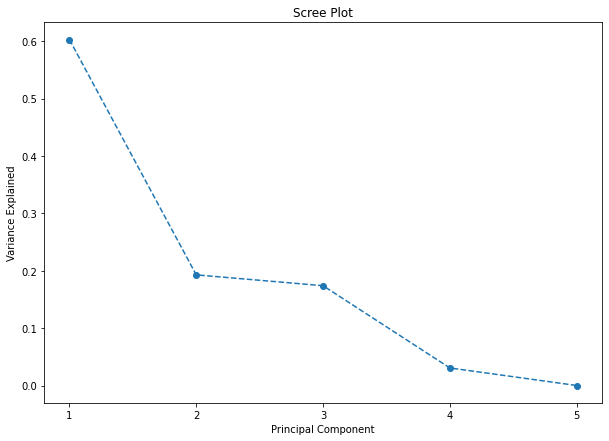

First component weights: [0.15628869 0.24969076 0.56268358 0.54812881 0.54421538]

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(range(1, 6), pca.explained_variance_ratio_, marker="o", linestyle="--")
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.xticks(range(1, 6))
plt.show()

print(f'First component weights: {pca.components_[0]}')

In [25]:
fc1_weights = np.abs(pca.components_[0]) / np.sum(np.abs(pca.components_[0]))
fc1_weights

array([0.07583122, 0.12114987, 0.27301388, 0.26595191, 0.26405312])

In [26]:
weights = [0.2, 0.10, 0.25, 0.25, 0.2]

In [27]:
scores_df = pd.DataFrame(
    scores_scaled,
    columns=[
        "closeness_centrality",
        "number_of_submissions",
        "number_of_comments",
        "respond_comment",
        "respond_submission",
    ],
)

scores_df["total_score"] = np.dot(scores_scaled, weights)
scores_df_sorted = scores_df.sort_values(by="total_score", ascending=False)
scores_df_sorted.set_index(centrality.index, inplace=True)

scores_df_sorted


,closeness_centrality,number_of_submissions,number_of_comments,respond_comment,respond_submission,total_score
node,,,,,,
AutoModerator,1.615353,4.768843,53.001044,52.239537,49.223461,36.954792
crimelabs786,1.777484,4.659935,52.161020,55.451232,34.934825,34.711518
srinivesh,1.646484,12.828102,43.429190,39.616177,50.997866,32.573022
vineetr,1.356810,27.204076,32.785200,27.272095,47.308970,27.467887
donoteatthatfrog,1.641963,0.412488,31.956229,37.577448,9.346028,19.622266
...,...,...,...,...,...,...
NeoStarSky97,-1.286718,-0.132057,-0.185748,-0.166956,-0.226424,-0.404010
harshvs25,-1.286718,-0.132057,-0.185748,-0.166956,-0.226424,-0.404010
NotYouAgain21,-1.286718,-0.132057,-0.185748,-0.166956,-0.226424,-0.404010


## Plot top 100 nodes

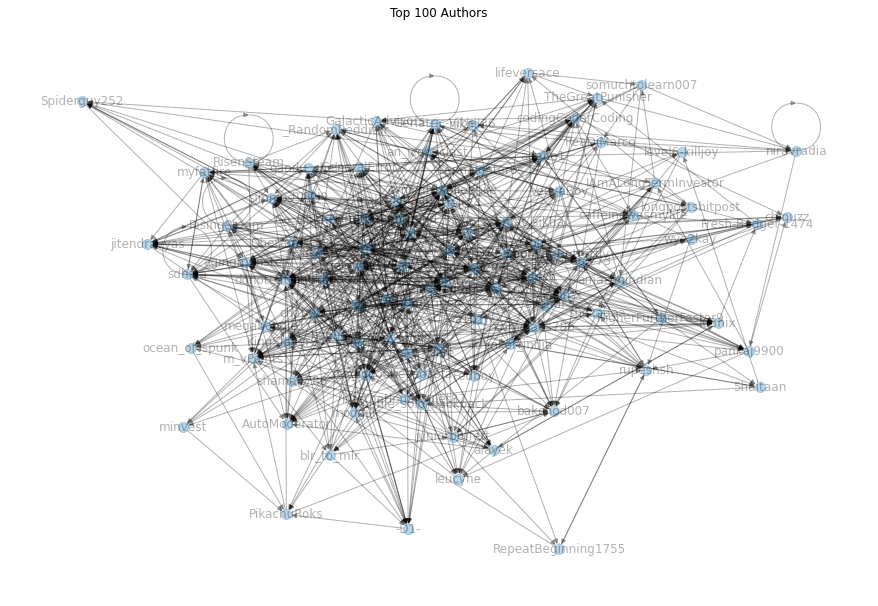

In [35]:
top_graph = G_comments_graph.subgraph(scores_df_sorted.index[:100])

plt.figure(figsize=(12, 8))
nx.draw(
    top_graph,
    with_labels=True,
    node_size=100,
    alpha=0.3,
    arrows=True,
    pos=nx.fruchterman_reingold_layout(top_graph),
)

plt.title("Top 100 Authors")
plt.savefig("top_100_authors.png", dpi=300)
plt.show()


In [32]:
sigma = Sigma(top_graph, default_node_color="lightblue", node_size=top_graph.degree, height=800)

sigma


Sigma(nx.DiGraph with 100 nodes and 923 edges)

In [33]:
sigma.to_html("top_100_authors.html")